# Assignment 2: Working with health data from wearables

In [1]:
# Not needed
# Design considerations
# Execute this cell to adjust the size of the jupyter notebook to the screen.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Data

In this assigment you will use the [Daily Sports and Activities](http://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities) dataset from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html). This dataset contains motion sensor data of 19 daily and sports activities (walking, running, rowing, jumping,...), each performed by 8 subjects in their own style for 5 minutes. Five Xsens MTx units are used on the torso, (right and left) arms, and (right and left) legs. 

----

## Objectives

- Understand time-series health data
- Perform pre-processing and visualisation on time-series data
- Extract features from time-series data
- Train a classifier to predict the activity the users are doing

----

## Exercise 1

Load, analyze and visualise the (temporal) data of the different sensors for subject 7 (p7). Compare walking on a treadmill with a speed of 4 km/h on a flat surface (a10) and running on a treadmill with a speed of 8 km/h (a12). Do you see any difference? Comment.
 

In [2]:
# Necessary libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score, learning_curve, GridSearchCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
%matplotlib inline

## Solution Exercise 1

**Data structure**: 
+ Folders a1,...,a19 for the 19 activities
+ For each folder, the subfolders p1, p2, ..., p8 contain data from each of the 8 subjects.
+ In each subfolder, there are 60 text files s01, s02, ..., s60, representing a 5 seconds segment of the 5 minutes exercise
+ In each text file... Each column contains 125 samples of data acquired from one of the sensors of one of the units over a period of 5 sec. Each row contains data acquired from all of the 45 sensor axes at a particular sampling instant separated by commas.
 + columns 1-9 correspond to the sensors in unit 1 (T),
 + columns 10-18 correspond to the sensors in unit 2 (RA),
 + columns 19-27 correspond to the sensors in unit 3 (LA),
 + columns 28-36 correspond to the sensors in unit 4 (RL),
 + columns 37-45 correspond to the sensors in unit 5 (LL).


Firstly, let us download the data of subject p7 for the activity a10 and a12. Let us start by analyzing a 5-second window of time, s01.

In [3]:
# Download data
df1 = pd.read_csv("data/a10/p7/s01.txt", header = None)
df2 = pd.read_csv("data/a12/p7/s01.txt", header = None)

# Visualize dataframe

#Function to create the column names
def create_columns(df):
    columns = []
    units = ["T","RA","LA","RL","LL"]
    axis = ["x","y","z"]
    sensor = ["acc","gyro","mag"]
    for unit in units:
        for sens in sensor:
            for ax in axis:
                name_col = "{}_{}{}".format(unit, ax, sens)
                columns.append(name_col)
    
    df.columns = columns
create_columns(df1)
create_columns(df2)
df1

,T_xacc,T_yacc,T_zacc,T_xgyro,T_ygyro,T_zgyro,T_xmag,T_ymag,T_zmag,RA_xacc,...,RL_zmag,LL_xacc,LL_yacc,LL_zacc,LL_xgyro,LL_ygyro,LL_zgyro,LL_xmag,LL_ymag,LL_zmag
0,9.3105,0.587000,-1.22880,-0.24365,-1.10660,0.037636,-0.72318,0.12456,-0.70206,5.0612,...,0.076493,-9.8361,-0.18946,-1.56540,-0.407760,0.37506,1.13070,1.0211,0.36735,-0.16518
1,12.0460,-0.086358,0.52566,-0.17974,0.85106,0.270410,-0.72236,0.13881,-0.69857,5.3809,...,0.081997,-9.1952,-2.43550,-0.94815,-0.036454,0.27783,0.87566,1.0460,0.34339,-0.18973
2,9.2470,-2.045200,10.73400,-1.55140,-0.60079,0.369790,-0.71560,0.16523,-0.70152,4.9954,...,0.075714,-8.5541,0.87487,-2.19080,-0.636590,0.42847,0.99528,1.0615,0.33070,-0.19799
3,7.4230,-2.820000,2.47950,-0.80663,0.22937,0.226170,-0.71067,0.19402,-0.70193,4.9443,...,0.019514,-9.1001,0.52867,-0.71447,-1.499400,0.35843,0.87873,1.0796,0.32330,-0.18596
4,4.4586,-1.529200,4.25580,0.33046,-0.11867,0.068550,-0.70185,0.20103,-0.70638,5.8938,...,-0.046420,-8.8194,-2.32180,0.22377,-0.307580,0.24665,0.94289,1.0974,0.31584,-0.16744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,9.9203,-0.835900,8.86020,-0.82225,-0.22458,0.625420,-0.78038,0.15126,-0.64627,4.2294,...,0.085754,-8.8908,0.99112,-1.18470,-1.101200,0.42872,1.08530,1.0685,0.32306,-0.16688
121,7.7014,-1.489700,0.78245,-0.30539,0.10452,0.220060,-0.77106,0.16165,-0.64888,3.9308,...,0.013187,-9.1912,0.13100,-0.46008,-1.199200,0.27667,0.93996,1.0893,0.31390,-0.15903
122,4.4964,-0.045998,3.71420,1.50890,0.43111,0.246540,-0.75089,0.15381,-0.66794,4.6780,...,-0.070790,-9.1684,0.40778,-0.60834,-0.505060,0.16847,1.04420,1.1119,0.30144,-0.15574
123,5.8095,0.416600,3.95090,0.69425,-0.62339,0.159830,-0.75325,0.13930,-0.66582,4.5113,...,-0.157270,-9.3541,2.18440,-2.16790,-0.624680,0.20184,1.11350,1.1288,0.28072,-0.14429


Let us plot the data. We are going to compare both activities using the data about the torso, right arm, left arm, right leg and left leg. In order not to make the visualization too long, since a priori, there is no difference between left and right arm and left and right leg, we will only plot one arm, one leg and the torso. Let us start with the torso.

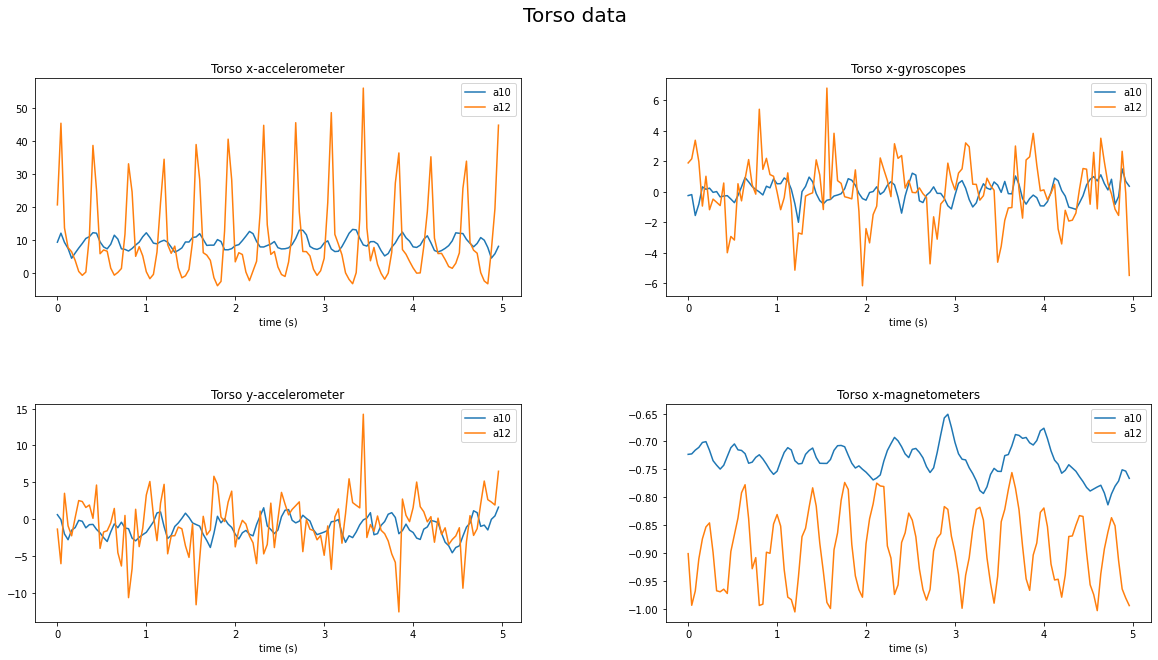

In [4]:
# Visualize data for a 5-sec window for the Torso
arr = np.arange(0.0, 5.0 ,0.04 )

# Create a figure object and an array of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# General title to the figure
fig.suptitle('Torso data', fontsize=20)

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Torso x-accelerometer
axs[0,0].plot(arr,df1['T_xacc'].values, label='a10')
axs[0,0].plot(arr,df2['T_xacc'].values, label='a12')
axs[0,0].legend()
axs[0,0].set_title('Torso x-accelerometer')
axs[0,0].set_xlabel('time (s)')

# Torso y-accelerometer
axs[1,0].plot(arr,df1['T_yacc'].values, label='a10')
axs[1,0].plot(arr,df2['T_yacc'].values, label='a12')
axs[1,0].legend()
axs[1,0].set_title('Torso y-accelerometer')
axs[1,0].set_xlabel('time (s)')

# Torso x-gyroscopes
axs[0,1].plot(arr,df1['T_xgyro'].values, label='a10')
axs[0,1].plot(arr,df2['T_xgyro'].values, label='a12')
axs[0,1].legend()
axs[0,1].set_title('Torso x-gyroscopes')
axs[0,1].set_xlabel('time (s)')

# Torso x-magnetometers
axs[1,1].plot(arr,df1['T_xmag'].values, label='a10')
axs[1,1].plot(arr,df2['T_xmag'].values, label='a12')
axs[1,1].legend()
axs[1,1].set_title('Torso x-magnetometers')
axs[1,1].set_xlabel('time (s)')

plt.show()

Let us continue with one arm, for example the right arm (RA).

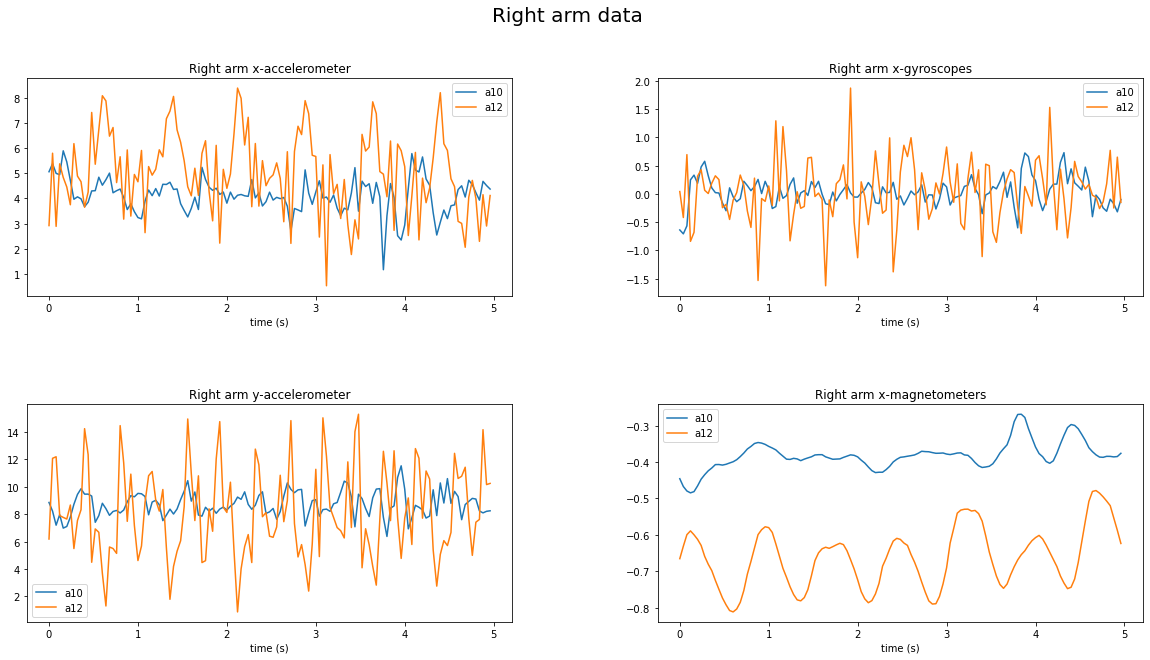

In [5]:
# Visualize data for a 5-sec window for the right arm
arr = np.arange(0.0, 5.0 ,0.04 )

# Create a figure object and an array of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# General title to the figure
fig.suptitle('Right arm data', fontsize=20)

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# RA x-accelerometer
axs[0,0].plot(arr,df1['RA_xacc'].values, label='a10')
axs[0,0].plot(arr,df2['RA_xacc'].values, label='a12')
axs[0,0].legend()
axs[0,0].set_title('Right arm x-accelerometer')
axs[0,0].set_xlabel('time (s)')

# RA y-accelerometer
axs[1,0].plot(arr,df1['RA_yacc'].values, label='a10')
axs[1,0].plot(arr,df2['RA_yacc'].values, label='a12')
axs[1,0].legend()
axs[1,0].set_title('Right arm y-accelerometer')
axs[1,0].set_xlabel('time (s)')

# RA x-gyroscopes
axs[0,1].plot(arr,df1['RA_xgyro'].values, label='a10')
axs[0,1].plot(arr,df2['RA_xgyro'].values, label='a12')
axs[0,1].legend()
axs[0,1].set_title('Right arm x-gyroscopes')
axs[0,1].set_xlabel('time (s)')

# RA x-magnetometers
axs[1,1].plot(arr,df1['RA_xmag'].values, label='a10')
axs[1,1].plot(arr,df2['RA_xmag'].values, label='a12')
axs[1,1].legend()
axs[1,1].set_title('Right arm x-magnetometers')
axs[1,1].set_xlabel('time (s)')

plt.show()

Finally, let us plot information about the left leg (LL).

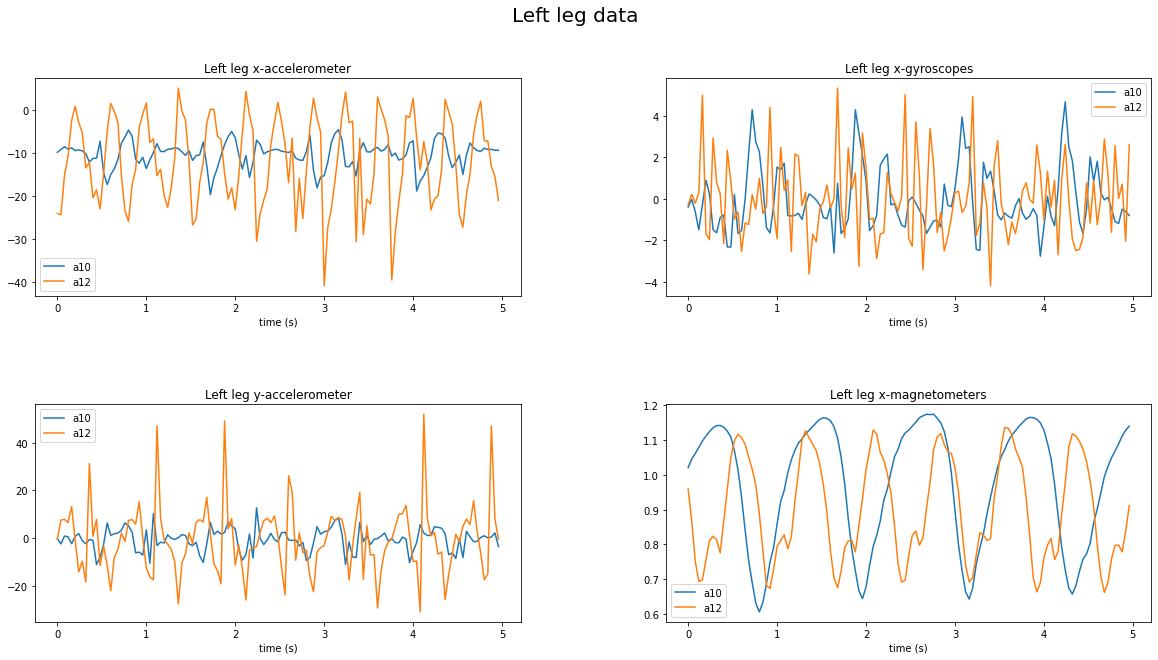

In [6]:
# Visualize data for a 5-sec window for the left leg
arr = np.arange(0.0, 5.0 ,0.04 )

# Create a figure object and an array of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# General title to the figure
fig.suptitle('Left leg data', fontsize=20)

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# LL x-accelerometer
axs[0,0].plot(arr,df1['LL_xacc'].values, label='a10')
axs[0,0].plot(arr,df2['LL_xacc'].values, label='a12')
axs[0,0].legend()
axs[0,0].set_title('Left leg x-accelerometer')
axs[0,0].set_xlabel('time (s)')

# LL y-accelerometer
axs[1,0].plot(arr,df1['LL_yacc'].values, label='a10')
axs[1,0].plot(arr,df2['LL_yacc'].values, label='a12')
axs[1,0].legend()
axs[1,0].set_title('Left leg y-accelerometer')
axs[1,0].set_xlabel('time (s)')

# LL x-gyroscopes
axs[0,1].plot(arr,df1['LL_xgyro'].values, label='a10')
axs[0,1].plot(arr,df2['LL_xgyro'].values, label='a12')
axs[0,1].legend()
axs[0,1].set_title('Left leg x-gyroscopes')
axs[0,1].set_xlabel('time (s)')

# LL x-magnetometers
axs[1,1].plot(arr,df1['LL_xmag'].values, label='a10')
axs[1,1].plot(arr,df2['LL_xmag'].values, label='a12')
axs[1,1].legend()
axs[1,1].set_title('Left leg x-magnetometers')
axs[1,1].set_xlabel('time (s)')

plt.show()

We have seen a comparison of the same subject doing different activities. In this case, notice that the activity a12 seems more physically demanding than activity a10. This make sense since, a10 is walking on a treadmill with a speed of 4 km/h on a flat surface and ,a12, is running on a treadmill with a speed of 8 km/h. To finish this first exercise, let us build two more plots, in which we show, for activities a01(sitting) and a02(standing), all the signals of a patient collected during the 5 minutes, just to make us a complete overview of the dataset.

In [7]:
# All the data from activity 1, subject 7
directory = 'data/a01/p7'
dfs = []
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    df = pd.read_csv(filepath,header = None)
    dfs.append(df)

df3 = pd.concat(dfs, ignore_index=True)
create_columns(df3)
df3

,T_xacc,T_yacc,T_zacc,T_xgyro,T_ygyro,T_zgyro,T_xmag,T_ymag,T_zmag,RA_xacc,...,RL_zmag,LL_xacc,LL_yacc,LL_zacc,LL_xgyro,LL_ygyro,LL_zgyro,LL_xmag,LL_ymag,LL_zmag
0,9.2445,-1.6626,2.6375,-0.014257,-0.028883,-0.013359,-1.1136,-0.31034,-0.28125,3.9449,...,-0.62487,-2.9964,-8.8239,-3.1286,-0.000193,-0.004692,0.004471,0.28927,0.45415,0.70422
1,9.2735,-1.7745,2.7564,-0.060222,0.032674,0.006382,-1.1126,-0.30851,-0.28308,3.9080,...,-0.62544,-2.9889,-8.7940,-3.1433,-0.007188,0.000345,-0.010859,0.28810,0.45349,0.70261
2,9.2657,-1.7455,2.9356,0.085650,0.027749,-0.022572,-1.1148,-0.30899,-0.28343,3.9401,...,-0.62487,-2.9740,-8.8465,-3.1283,-0.003668,0.011292,-0.001754,0.28948,0.45350,0.70331
3,9.3333,-1.7305,2.7497,-0.023559,0.136690,0.027880,-1.1119,-0.30926,-0.28425,3.9867,...,-0.62357,-2.9664,-8.8091,-3.1281,0.016300,0.012093,-0.009943,0.28868,0.45323,0.70316
4,9.0873,-1.8684,2.5455,-0.019171,0.086083,0.008000,-1.1116,-0.30798,-0.28903,3.9744,...,-0.62539,-2.9590,-8.8241,-3.1429,-0.004673,0.012347,0.006388,0.28876,0.45429,0.70261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,9.4373,-1.9091,2.2782,0.000249,0.000266,-0.012086,-1.1353,-0.29697,-0.24797,3.7403,...,-0.67055,-2.9478,-8.7711,-3.1424,0.001062,-0.005398,-0.011607,0.28859,0.45009,0.70254
7496,9.4079,-1.8494,2.2262,0.050927,-0.010906,-0.015620,-1.1341,-0.29897,-0.24551,3.7551,...,-0.66892,-2.9403,-8.7561,-3.1646,0.002900,0.011674,-0.009693,0.28847,0.45048,0.70279
7497,9.3857,-1.8638,2.1662,-0.032211,0.029192,-0.007704,-1.1344,-0.29856,-0.24632,3.7402,...,-0.67109,-2.9329,-8.8159,-3.1572,-0.004550,0.008391,0.006584,0.28798,0.45074,0.70344
7498,9.3334,-1.8930,2.1507,0.024052,0.053017,-0.005000,-1.1352,-0.29857,-0.24555,3.7109,...,-0.66989,-2.9629,-8.8009,-3.1427,-0.018957,-0.002520,0.001132,0.28852,0.45035,0.70346


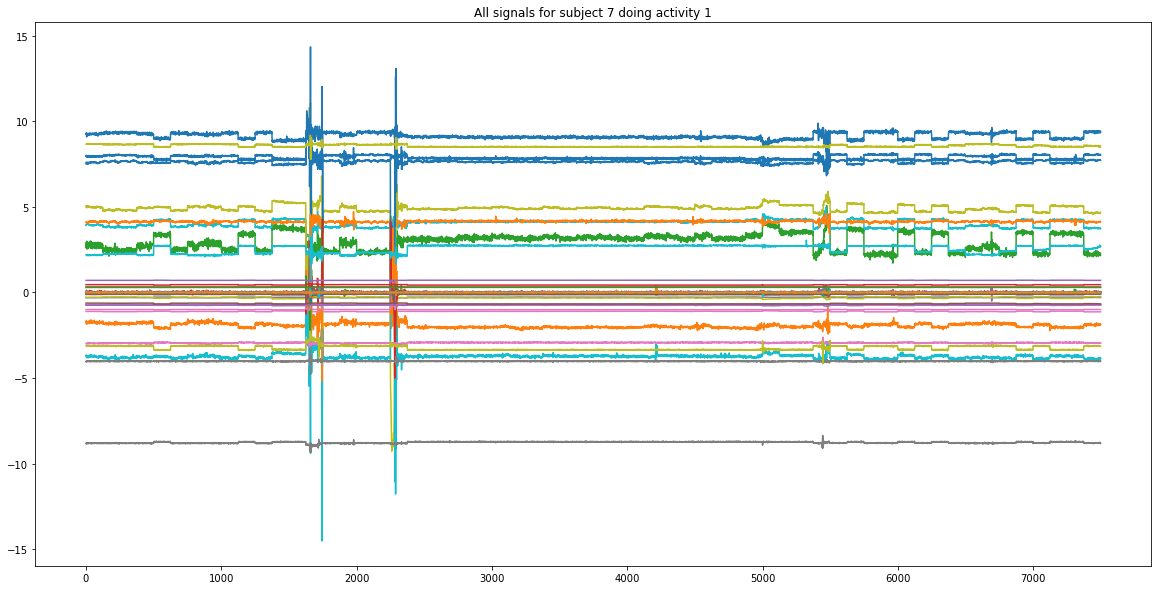

In [8]:
df3.plot(figsize=(20,10), legend=None)
plt.title('All signals for subject 7 doing activity 1')
plt.show()

In [9]:
# All the data from activity 2, subject 7
directory = 'data/a02/p7'
dfs = []
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    df = pd.read_csv(filepath,header = None)
    dfs.append(df)

df4 = pd.concat(dfs, ignore_index=True)
create_columns(df4)
df4

,T_xacc,T_yacc,T_zacc,T_xgyro,T_ygyro,T_zgyro,T_xmag,T_ymag,T_zmag,RA_xacc,...,RL_zmag,LL_xacc,LL_yacc,LL_zacc,LL_xgyro,LL_ygyro,LL_zgyro,LL_xmag,LL_ymag,LL_zmag
0,8.7080,-1.2210,4.4464,0.012043,0.072964,-0.006518,-0.72413,0.48592,-0.25409,8.2587,...,0.48618,-9.7820,-0.000847,-0.50379,0.020343,0.018758,-0.016525,0.58449,-0.068454,-0.30098
1,8.6341,-1.1753,4.2671,-0.006319,0.024721,0.000945,-0.72311,0.48693,-0.25458,8.2735,...,0.48498,-9.7969,0.051508,-0.50390,0.005770,0.008101,-0.009320,0.58544,-0.067409,-0.30200
2,8.6934,-1.1396,4.4915,-0.016224,0.032781,-0.010941,-0.72507,0.48689,-0.25702,8.2538,...,0.48460,-9.8120,-0.015644,-0.50433,0.033656,0.001149,-0.003998,0.58562,-0.068453,-0.29965
3,8.7382,-1.1765,4.3723,-0.011604,0.040665,-0.021003,-0.72334,0.48622,-0.25642,8.2489,...,0.48497,-9.7670,-0.000918,-0.50353,0.031361,0.007707,-0.032913,0.58444,-0.068578,-0.30162
4,8.6708,-1.1913,4.4910,-0.041442,0.053458,-0.019276,-0.72291,0.48595,-0.25588,8.2664,...,0.48486,-9.8043,0.103880,-0.51882,-0.002221,0.010579,-0.018327,0.58660,-0.068821,-0.30065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,8.5711,-1.5130,4.4870,-0.052713,0.031330,-0.032922,-0.69948,0.51242,-0.26965,8.2481,...,0.48988,-9.7948,-0.141970,-0.39608,0.044902,-0.003727,-0.019590,0.58193,-0.051819,-0.30570
7496,8.6160,-1.5057,4.4277,-0.026612,-0.009318,-0.042742,-0.69903,0.51290,-0.26871,8.3099,...,0.49044,-9.8172,-0.082103,-0.39629,0.020412,-0.002730,-0.010470,0.58060,-0.052087,-0.30612
7497,8.5860,-1.5792,4.3375,-0.120710,0.024803,-0.016579,-0.70063,0.51413,-0.26641,8.3980,...,0.49090,-9.8173,-0.134490,-0.36656,-0.011042,-0.012068,-0.023116,0.58161,-0.052590,-0.30674
7498,8.6603,-1.5214,4.5473,0.013183,-0.010344,-0.034466,-0.70186,0.51111,-0.26736,8.3536,...,0.49116,-9.8397,-0.111880,-0.39675,0.004959,-0.006217,-0.003208,0.58161,-0.052462,-0.30661


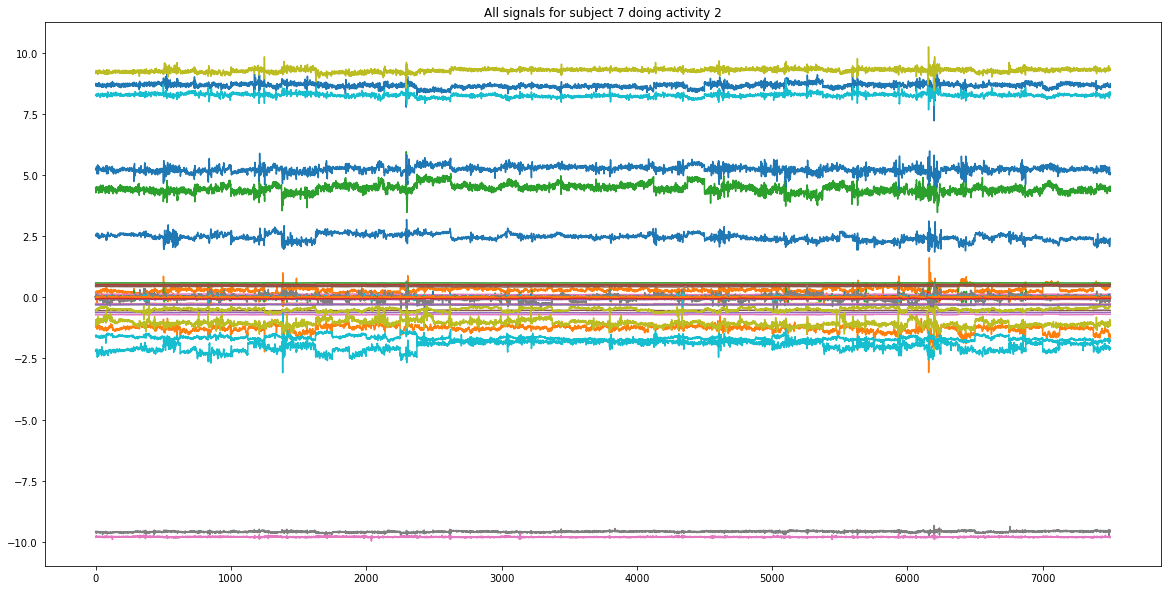

In [10]:
df4.plot(figsize=(20,10), legend=None)
plt.title('All signals for subject 7 doing activity 2')
plt.show()

## Exercise 2

Build a model (classifier) to predict the activity of a given subject. Decide on which features could be extracted from the data. For example:

- **mean, variance,skewness, and the kurtosis**. The distribution of each signal are approximately Normal. This means that we can take the first four statistical moments for each 5 second segment. By including the four moments, we are helping our models better learn the characteristic of each unique activity. 
- n first values of the  the  [**autocorrelation**](https://en.wikipedia.org/wiki/Autocorrelation) sequence. In some time series analyses, such as in [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), it is desirable to minimize autocorrelation so as to transform the series into a [stationary state](https://en.wikipedia.org/wiki/Stationary_process). 
- n peaks of the [**discrete Fourier transform**](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)
of a segment with the corresponding frequencies.

Consider normalising all features between [0,1] and reduce the dimension of features using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).


We propose 2 approaches to create your train/testing set.

(1) Train and test sets that contain shuffled samples from each user. So the model will train on data from every user and predict the activities from every user in the test set.
(2) Seven user's data will be used as the training set and only one user's data as the test set. The goal here is to predict the activities of a user that the model has never seen before. How good is the model generalising the problem?

For each approach, consider the following building framework:
1. Split data into train and holdout sets
2. Optimize model hyperparameters
3. Cross Validate model's performance by analyze learning curves

Finally, consider the follwing evaluation metrics:

**Accuracy** represents how close or far off a given set of measurements are to their true value.

**Precision**: percentage of classifications predicted to be positive are actually positive. **Precision is a measure of the failure to correctly predict positive classifications. **

$$\textbf{Precision} = \frac{TP}{TP + FP}, $$

where TP refers to True Positives and FP to False Positives. 

**Recall** describes how well the model can identify points that belong to the positive class. **Recall is a measure of the failure in distinguishing between positive and negative classifications. **

$$\textbf{Recall} = \frac{TP}{TP + FN},$$

where FN corresponds to False Negatives.

Finally, the $f_{1} score$ is a weighted average of precision and recall. The  $f_{1} score$  is used to get a measure of both types of failures.

**Note: Make comments on the code to discuss the results.**
 

## Solution Exercise 2

## Pre-processing

Let us start by deciding which features could be extracted from the data. We will proceed according to the recommendations of the exercise. Let us compute the mean, variance, skewness, Kurtosis and autocorrelation for each 5-seconds segment of a sensor, for every subject and  for any activity. We will create a dataframe with 225(=45 $\times$ 5) columns and 9120 (=19 $\times$8 $\times$ 60) rows.

### Mean, Variance, Skewness , Kurtosis and Autocorrelation

First, let us implement a function that creates an empty dataframe with de desire columns.

In [11]:
# Create an empty dataframe with the desire columns
def create_columns_extra(df):
    columns = []
    statistic = ['mean','var','ske','kurt','autocorr']
    units = ["T","RA","LA","RL","LL"]
    axis = ["x","y","z"]
    sensor = ["acc","gyro","mag"]
    for stat in statistic:
        for unit in units:
            for sens in sensor:
                for ax in axis:
                    name_col = "{}_{}{}_{}".format(unit, ax, sens, stat)
                    columns.append(name_col)
    
    df.columns = columns
df_final = pd.DataFrame(columns=range(225))
create_columns_extra(df_final)

Let us build the dataframe with the statisticals measures as features. As said before, we should have 9120 rows and 225 columns of statistical nature. We will add one more column to indicate the activity of each row.

In [12]:
# Build the dataframe
activity_list = []
print('Creating dataframe with columns of statistical nature')
for i in tqdm(range(1,20)): # each activity
    for j in range(1,9):# each subject
        for filename in os.listdir('data/a'+str(i).zfill(2)+'/p'+str(j)):# each segment
            directory = 'data/a'+str(i).zfill(2)+'/p'+str(j)
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath,header = None)# read each txt file
            
            # Statistical computations
            segment_mean = df.mean(axis = 0).tolist() # mean
            segment_variance = df.var(axis = 0).tolist()# variance
            segment_skewness = df.skew(axis = 0).tolist()# skewness
            segment_kurtosis = df.kurtosis(axis = 0).tolist()# kurtosis
            segment_autocorr = df.apply(lambda col: col.autocorr(lag=1), axis=0).tolist()# autocorrelation
    
            # Create a unic list
            segment_mean.extend(segment_variance)
            segment_mean.extend(segment_skewness)
            segment_mean.extend(segment_kurtosis)
            segment_mean.extend(segment_autocorr)
            
            # Append the final row to our dataframe
            df_final.loc[len(df_final)] = segment_mean
            
            # Actualize the activity list
            activity_list.append(i)
            
# Create the target column using the activity_list
df_final['activity'] = activity_list

Creating dataframe with columns of statistical nature


100%|███████████████████████████████████████████| 19/19 [01:34<00:00,  5.00s/it]


In [13]:
# Visualization of our dataframe
df_final

,T_xacc_mean,T_yacc_mean,T_zacc_mean,T_xgyro_mean,T_ygyro_mean,T_zgyro_mean,T_xmag_mean,T_ymag_mean,T_zmag_mean,RA_xacc_mean,...,LL_xacc_autocorr,LL_yacc_autocorr,LL_zacc_autocorr,LL_xgyro_autocorr,LL_ygyro_autocorr,LL_zgyro_autocorr,LL_xmag_autocorr,LL_ymag_autocorr,LL_zmag_autocorr,activity
0,7.965544,1.150181,5.599276,0.002584,0.022276,-0.003579,-0.792878,-0.072232,0.136133,0.559089,...,0.376057,0.130342,0.270931,-0.029748,0.068167,0.012995,-0.185938,-0.073688,-0.064793,1
1,7.889739,1.223062,5.697052,0.002427,0.022816,-0.001350,-0.793816,-0.073598,0.126730,0.473913,...,0.301645,0.003459,0.384447,0.219560,-0.070938,-0.081198,-0.008240,-0.121154,0.045004,1
2,7.877556,1.240731,5.718400,0.001117,0.019416,-0.002307,-0.793560,-0.073579,0.125058,0.460251,...,0.170393,0.171627,0.477245,0.396982,0.048681,0.015808,-0.139334,-0.181873,-0.081659,1
3,7.923159,1.161473,5.667376,0.003561,0.023468,-0.003175,-0.793819,-0.072314,0.130159,0.540004,...,0.098049,-0.140552,0.115326,-0.183520,0.063133,-0.003419,-0.075764,-0.114007,0.013952,1
4,7.867894,1.399373,5.697364,0.002806,0.018757,-0.002986,-0.790545,-0.075076,0.127004,0.211069,...,0.184302,-0.097108,-0.074525,-0.025703,0.015710,-0.067028,0.064839,0.105146,0.109169,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,9.329064,-1.120049,0.506809,-0.134408,0.027870,-0.109561,-0.687982,-0.207986,-0.354463,6.482291,...,0.618915,0.210453,0.326471,0.579814,0.684871,0.736535,0.990387,0.992237,0.991133,19
9116,9.468289,-0.333723,0.639205,0.043480,0.048001,-0.035477,-0.706111,-0.420412,-0.038388,6.962207,...,0.540925,0.150301,0.485500,0.723476,0.537792,0.819447,0.980414,0.987281,0.964465,19
9117,9.740978,-0.397015,2.222914,-0.152231,-0.100953,0.006083,-0.598632,0.036041,-0.601300,7.249543,...,0.345994,0.400220,0.498721,0.335994,0.588177,0.775123,0.962635,0.945819,0.962959,19
9118,9.325027,-0.269696,0.312796,-0.539550,-0.005005,0.012998,-0.746831,0.207412,0.045568,4.491775,...,0.699878,0.454582,0.447839,0.783110,0.737037,0.817684,0.958147,0.996653,0.977430,19


## Training and predicting

Let us start by normalizing our data and reducing the dimension of features using PCA, since we have too many features. Firstly, let us split the data into training and test. We will use the first approach for creating our train/test set stated in this notebook.

In [14]:
# Train/test split
X = df_final.iloc[:, :-1]
y = df_final['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, shuffle = True)

# Normalization of all features between [0,1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Dimensionality reduction selecting the components such that the amount of variance that needs to be explained is greater than 90%
pca = PCA(n_components = 0.9)
X_red = pca.fit_transform(X_train_scaled)
X_train_red = pd.DataFrame(X_red)

Let us visualize what is doing our PCA. Let us build a plot to show explained variance ratio(cumulative and individual) for each principal component.

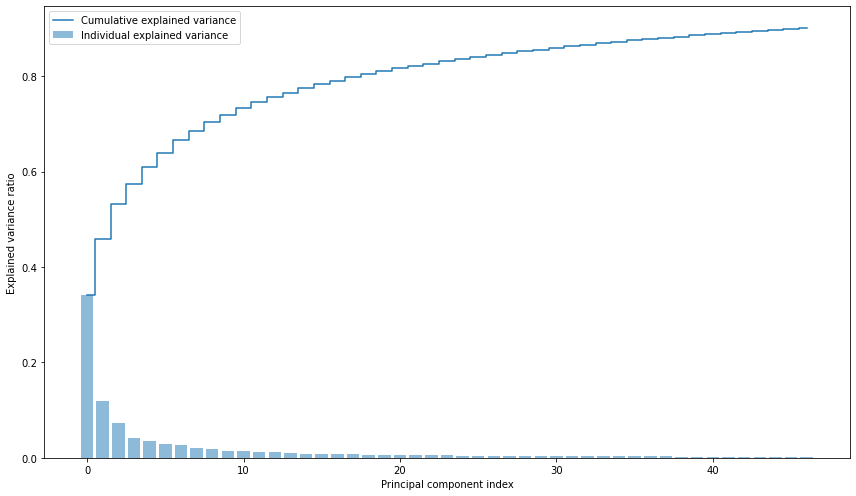

The total principal components needed such that the amount of variance that needs to be explained is greater than 90% are: 47


In [15]:
# Determine explained variance 
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.figure(figsize=(12, 7))

# Plot the bar and step charts
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

# Set the axis labels and legend
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
# Adjust the spacing
plt.tight_layout()
plt.show()
print('The total principal components needed such that the amount of variance that needs to be explained is greater than 90% are:',len(exp_var_pca))

In [16]:
# Transform also the test set
X_test_red = pd.DataFrame(pca.transform(X_test_scaled))

## Model selection
Now, it is time to choose our classifier. Firslty, let us implement a function to compute the learning curve of the classifier.

In [17]:
# Learning curve function
def Learning_Curve(clf, X, y):
    # Calculate the learning curve using cross-validation
    train_sizes, train_scores, test_scores = learning_curve(clf,
                                                            X, y, cv=5, scoring='accuracy',
                                                            train_sizes=np.linspace(0.01, 1.0, 50))
    
    # Calculate the mean and standard deviation of the training and testing scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.subplots(1, figsize=(8,8))
    plt.plot(train_sizes, train_mean, '--', color="black",  label="Training score")
    plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

Let us test three models to choose our classifier, a Support Vector Machine, a K-Nearest Neighbors and a XGBoost. Let us observe the results!

### Support Vector Machines

In [30]:
# Train an SVM classifier
print('SUPPORT VECTOR MACHINES')
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_red, y_train)

# Predict the labels of the test set
y_pred = clf_svm.predict(X_test_red)

# Calculate the accuracy of the classifier
scores = cross_val_score(clf_svm, X_train_red, y_train, cv=5)
print("%0.5f mean accuracy of the cross validation with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

# Create taget names for the classification report
target = []
for i in range(1,20):
    target.append('a'+str(i).zfill(2))

print(classification_report(y_test, y_pred,target_names = target))

SUPPORT VECTOR MACHINES
0.98997 mean accuracy of the cross validation with a standard deviation of 0.00181
              precision    recall  f1-score   support

         a01       1.00      1.00      1.00       156
         a02       0.98      1.00      0.99       140
         a03       1.00      1.00      1.00       163
         a04       1.00      1.00      1.00       147
         a05       1.00      1.00      1.00       133
         a06       1.00      0.99      0.99       137
         a07       0.95      0.86      0.91       162
         a08       0.83      0.95      0.89       128
         a09       1.00      1.00      1.00       148
         a10       0.99      1.00      1.00       152
         a11       1.00      0.99      1.00       141
         a12       1.00      1.00      1.00       143
         a13       1.00      1.00      1.00       141
         a14       1.00      1.00      1.00       129
         a15       1.00      1.00      1.00       145
         a16       1.00     

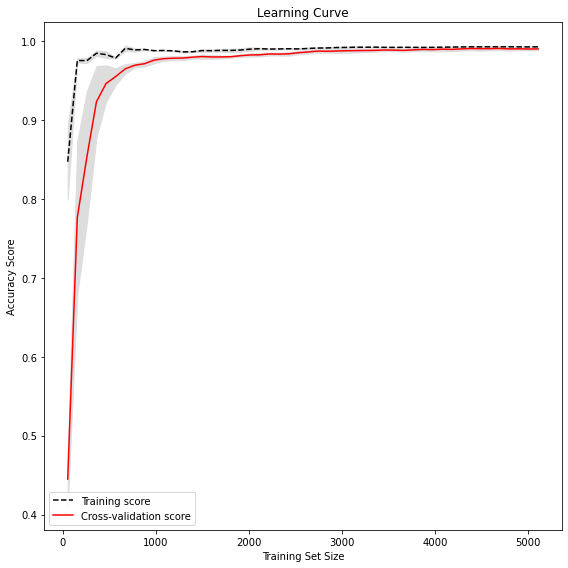

CPU times: user 4min 2s, sys: 743 ms, total: 4min 3s
Wall time: 4min 3s


In [19]:
%%time
# Learning Curve
Learning_Curve(clf_svm,X_train_red,y_train)

In [20]:
# Table to show the relationship between predicted/actual activity. 
# The more diagonal, the better!
pd.crosstab(y_test, y_pred, rownames=['Actual Activity'], colnames=['Predicted Activity'])

Predicted Activity,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Actual Activity,,,,,,,,,,,,,,,,,,,
1,156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,135,0,2,0,0,0,0,0,0,0,0,0,0,0
7,0,3,0,0,0,0,140,19,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,7,121,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,148,0,0,0,0,0,0,0,0,0,0


### K-Nearest Neighbors

In [21]:
# Train an KNN classifier
print('K-NEAREST NEIGHBORS')
# Choose the better k
neighbors_list = []
for n in range(3,10):
    clf_KN = KNeighborsClassifier(n_neighbors = n)
    clf_KN.fit(X_train_red, y_train)

    # Calculate the accuracy of every  classifier
    scores = cross_val_score(clf_KN, X_train_red, y_train, cv=5)
    print("%0.5f mean accuracy for k = %0.2f of the cross validation with a standard deviation of %0.5f" % (scores.mean(),n, scores.std()))
    neighbors_list.append(scores.mean())
    
# Choose the better and use this as our classifier
best_k = neighbors_list.index(max(neighbors_list)) + 3
print('The best KNN classifier is perform by k =', best_k,'. Let us study this case')
clf_KN = KNeighborsClassifier(n_neighbors = best_k)
clf_KN.fit(X_train_red, y_train)

# Predict the labels of the test set
y_pred = clf_KN.predict(X_test_red)

# Create taget names for the classification report
target = []
for i in range(1,20):
    target.append('a'+str(i).zfill(2))

print(classification_report(y_test, y_pred,target_names = target))

K-NEAREST NEIGHBORS
0.98794 mean accuracy for k = 3.00 of the cross validation with a standard deviation of 0.00283
0.98637 mean accuracy for k = 4.00 of the cross validation with a standard deviation of 0.00274
0.98763 mean accuracy for k = 5.00 of the cross validation with a standard deviation of 0.00235
0.98512 mean accuracy for k = 6.00 of the cross validation with a standard deviation of 0.00253
0.98575 mean accuracy for k = 7.00 of the cross validation with a standard deviation of 0.00245
0.98371 mean accuracy for k = 8.00 of the cross validation with a standard deviation of 0.00286
0.98449 mean accuracy for k = 9.00 of the cross validation with a standard deviation of 0.00290
The best KNN classifier is perform by k = 3 . Let us study this case
              precision    recall  f1-score   support

         a01       1.00      1.00      1.00       156
         a02       0.97      1.00      0.99       140
         a03       1.00      1.00      1.00       163
         a04       1.0

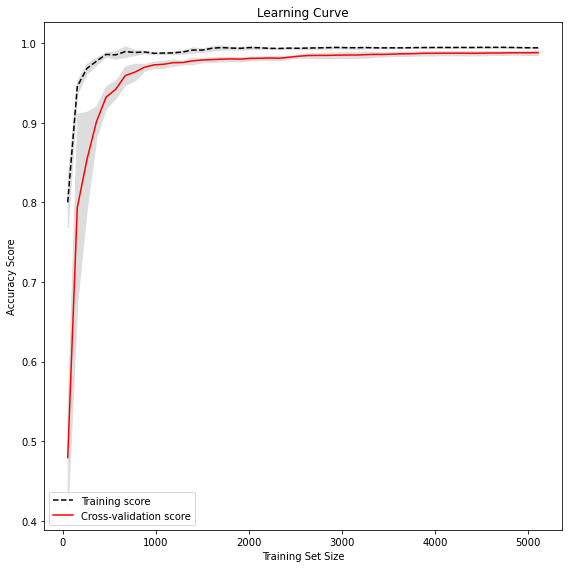

CPU times: user 4min 25s, sys: 1min 3s, total: 5min 28s
Wall time: 47.7 s


In [22]:
%%time
# Learning Curve
Learning_Curve(clf_KN,X_train_red,y_train)

In [23]:
# Table to show the relationship between predicted/actual activity. 
# The more diagonal, the better!
pd.crosstab(y_test, y_pred, rownames=['Actual Activity'], colnames=['Predicted Activity'])

Predicted Activity,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Actual Activity,,,,,,,,,,,,,,,,,,,
1,156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,137,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,4,0,0,0,1,140,17,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,2,0,7,119,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,148,0,0,0,0,0,0,0,0,0,0


### XGBoost

In [24]:
# Train an XGB classifier
print('XGBOOST')
clf_xgb = xgb.XGBClassifier(random_state=42)
le = LabelEncoder()# needed for xgboost
y_train_xgb = le.fit_transform(y_train)
y_test_xgb = le.fit_transform(y_test)
clf_xgb.fit(X_train_red, y_train_xgb)

# Predict the labels of the test set
y_pred = clf_xgb.predict(X_test_red)

# Calculate the accuracy of the classifier
scores = cross_val_score(clf_xgb, X_train_red, y_train_xgb, cv=5)
print("%0.5f mean accuracy of the cross validation with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

# Create taget names for the classification report
target = []
for i in range(1,20):
    target.append('a'+str(i).zfill(2))

print(classification_report(y_test_xgb, y_pred,target_names = target))

XGBOOST
0.98355 mean accuracy of the cross validation with a standard deviation of 0.00210
              precision    recall  f1-score   support

         a01       0.99      0.99      0.99       156
         a02       0.97      0.99      0.98       140
         a03       1.00      0.97      0.98       163
         a04       1.00      0.99      1.00       147
         a05       0.98      0.99      0.99       133
         a06       1.00      0.98      0.99       137
         a07       0.97      0.88      0.92       162
         a08       0.84      0.91      0.88       128
         a09       0.98      1.00      0.99       148
         a10       0.98      0.99      0.99       152
         a11       0.99      0.96      0.98       141
         a12       1.00      1.00      1.00       143
         a13       0.98      0.99      0.98       141
         a14       0.99      0.99      0.99       129
         a15       0.99      1.00      1.00       145
         a16       1.00      1.00      1.00 

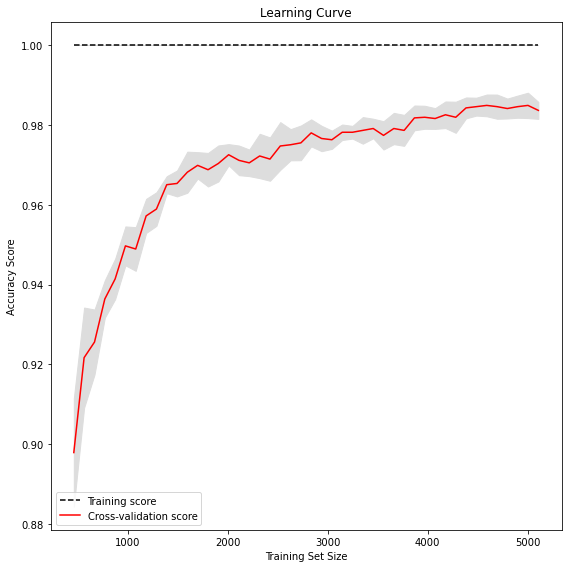

CPU times: user 53min 14s, sys: 1min 31s, total: 54min 45s
Wall time: 7min 3s


In [25]:
%%time
# Learning curve
Learning_Curve(clf_xgb,X_train_red,y_train_xgb)

In [26]:
# Table to show the relationship between predicted/actual activity. 
# The more diagonal, the better!
pd.crosstab(y_test_xgb, y_pred, rownames=['Actual Activity'], colnames=['Predicted Activity'])

Predicted Activity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Actual Activity,,,,,,,,,,,,,,,,,,,
0,155,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,139,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,158,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2
3,0,0,0,146,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,132,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,134,0,3,0,0,0,0,0,0,0,0,0,0,0
6,0,3,0,0,0,0,143,16,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,2,0,4,117,1,0,0,0,0,1,0,0,0,0,2
8,0,0,0,0,0,0,0,0,148,0,0,0,0,0,0,0,0,0,0


Let us make a summary of the classifiers

In [27]:
data = {'Classifier': ['SVM', 'K-NN,k=3', 'XGboost'],
        'Mean-Accuracy': [0.98997, 0.98794, 0.98355],
        'Standard Deviation': [0.00181, 0.00283, 0.00210],
        'Precision':[0.99 ,0.99 ,0.98],
        'Recall':[0.99 ,0.99 ,0.98],
        'f1-score':[0.99, 0.99 ,0.98 ]}
pd.DataFrame(data)

,Classifier,Mean-Accuracy,Standard Deviation,Precision,Recall,f1-score
0,SVM,0.98997,0.00181,0.99,0.99,0.99
1,"K-NN,k=3",0.98794,0.00283,0.99,0.99,0.99
2,XGboost,0.98355,0.00210,0.98,0.98,0.98


It seems that Support Vector Machines is slightly better than K-NN or XGBoost. Let us try some hyperparameter tuning on SVM in order to improve the result a bit.

In [28]:
%%time
# Train an SVM classifier
print('SUPPORT VECTOR MACHINES')

# Create a Support Vector Machines
clf_svm = SVC(random_state=42)

#Hyperparameter Optimization
param_grid = { 'C':[0.1,1,100,1000],
              'kernel':['rbf','sigmoid','linear'],
              'degree':[1,2,4,5,6]}
print('Performing hyperparameter tuning...')
#Run the grid search
grid_obj = GridSearchCV(clf_svm, param_grid,cv=5)
grid_obj = grid_obj.fit(X_train_red, y_train)

#Set the classifier to the best combination of parameters
est = grid_obj.best_estimator_

est.fit(X_train_red, y_train)
# Predict the labels of the test set
y_pred = est.predict(X_test_red)

# Calculate the accuracy of the classifier
scores = cross_val_score(est, X_train_red, y_train, cv=5)
print("%0.5f mean accuracy of the cross validation with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

# Create taget names for the classification report
target = []
for i in range(1,20):
    target.append('a'+str(i).zfill(2))

print(classification_report(y_test, y_pred,target_names = target))

SUPPORT VECTOR MACHINES
Performing hyperparameter tuning...
0.99232 mean accuracy of the cross validation with a standard deviation of 0.00264
              precision    recall  f1-score   support

         a01       1.00      1.00      1.00       156
         a02       1.00      1.00      1.00       140
         a03       1.00      1.00      1.00       163
         a04       1.00      1.00      1.00       147
         a05       1.00      1.00      1.00       133
         a06       1.00      0.99      0.99       137
         a07       0.96      0.89      0.92       162
         a08       0.86      0.95      0.90       128
         a09       1.00      1.00      1.00       148
         a10       1.00      1.00      1.00       152
         a11       1.00      1.00      1.00       141
         a12       1.00      1.00      1.00       143
         a13       1.00      1.00      1.00       141
         a14       1.00      1.00      1.00       129
         a15       1.00      1.00      1.00   

In [29]:
# Table to show the relationship between predicted/actual activity. 
# The more diagonal, the better!
pd.crosstab(y_test, y_pred, rownames=['Actual Activity'], colnames=['Predicted Activity'])

Predicted Activity,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Actual Activity,,,,,,,,,,,,,,,,,,,
1,156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,135,0,2,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,144,18,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,6,122,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,148,0,0,0,0,0,0,0,0,0,0


Finally, with the hyperparameter tuning, we have reached 0.99232 mean accuracy of the cross validation with a standard deviation of 0.00264. Moreover, if we take a closer look at the results, we can observe that the activities that are most difficult to predict are a07 and a08. Actually, the classifier is confused only in these two activities(see the last crosstab table) and it is not strange, because the activities are really similar to each other, a07 is standing in an elevator still and a08 is moving around in an elevator.